# **IMPORTS**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf

In [ ]:
import numpy as np

In [ ]:
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
pdr.get_data_yahoo = pdr.get_data_yahoo

In [ ]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2019, 1, 1)

tickers = ['ADBE', 'MSFT']

In [ ]:
df = yf.download(tickers, start, end)['Close']
df.head()

[*********************100%***********************]  2 of 2 completed


Ticker,ADBE,MSFT
Date,,
2013-01-02,38.340000,27.620001
2013-01-03,37.750000,27.250000
2013-01-04,38.130001,26.740000
2013-01-07,37.939999,26.690001
2013-01-08,38.139999,26.549999


# **Visualizing the stock trends**

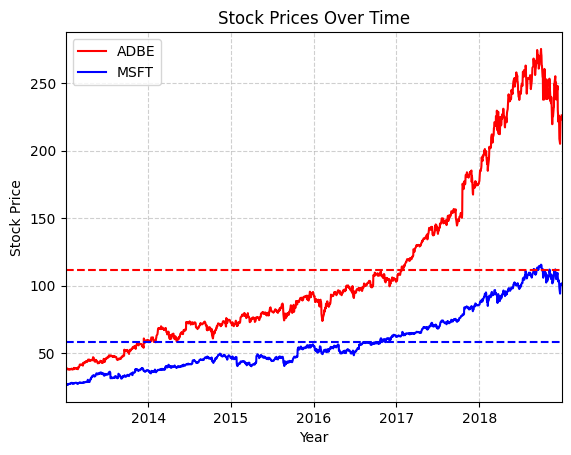

In [ ]:
plt.plot(df.index, df['ADBE'], color='r', label='ADBE')
plt.plot(df.index, df['MSFT'], color='b', label='MSFT')
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Stock Prices Over Time')
plt.legend()

mean_adbe = np.mean(df['ADBE'])
mean_msft = np.mean(df['MSFT'])
plt.hlines(mean_adbe, df.index.min(), df.index.max(), linestyles='dashed', colors='r', label=f'ADBE Mean ({mean_adbe:.2f})')
plt.hlines(mean_msft, df.index.min(), df.index.max(), linestyles='dashed', colors='b', label=f'MSFT Mean ({mean_msft:.2f})')

plt.grid(True, linestyle='--', alpha=0.6)

plt.xlim([df.index.min(), df.index.max()])

plt.show()

# **Stationary Tests for Pairs Trading**

## ADF Test

In [ ]:
def stationarity_test(X, cutoff=0.01):
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

In [ ]:
stationarity_test(df['ADBE'])
stationarity_test(df['MSFT'])

p-value = 0.9834137419388983 The series ADBE is likely non-stationary.
p-value = 0.973361220454393 The series MSFT is likely non-stationary.


## Co-integration

In [ ]:
def cointegration(stock1, stock2):
  score, pvalue, _ = coint(stock1, stock2)
  return score, pvalue

In [ ]:
score, pvalue = cointegration(df['ADBE'], df['MSFT'])
print(f"The score is:{score}")
print(f"The p-value is:{pvalue}")

The score is:-3.380810720060439
The p-value is:0.04452696271616674


## Co-relation

In [ ]:
def calc_corr(stock1, stock2):
  corr = stock1.corr(stock2)
  return corr

In [ ]:
corr = calc_corr(df['ADBE'], df['MSFT'])
print(f"The co-relation between the two stocks is:{corr}")

The co-relation between the two stocks is:0.990100768396563


# **Making the features**

In [ ]:
stock1 = df['ADBE']
stock2 = df['MSFT']

In [ ]:
data = pd.DataFrame({
    'ADBE':stock1,
    'MSFT': stock2
})

In [ ]:
data['ratio'] = data['ADBE']/data['MSFT']

In [ ]:
data['SMA_5'] = data['ratio'].rolling(window=5).mean()
data['SMA_20'] = data['ratio'].rolling(window=20).mean()
data['SMA_60'] = data['ratio'].rolling(window=60).mean()

In [ ]:
data['ROC_5'] = data['ratio'].pct_change(periods=5) * 100

In [ ]:
data['std'] = data['ratio'].rolling(window=60).std()

In [ ]:
data['Lag_1'] = data['ratio'].shift(1)
data['Lag_2'] = data['ratio'].shift(2)
data['Lag_3'] = data['ratio'].shift(3)

In [ ]:
data = data.dropna()

In [ ]:
data.head()

,ADBE,MSFT,ratio,SMA_5,SMA_20,SMA_60,ROC_5,std,Lag_1,Lag_2,Lag_3
Date,,,,,,,,,,,
2013-03-28,43.520000,28.610001,1.521146,1.514580,1.482384,1.426073,1.373701,0.046439,1.503701,1.518111,1.508878
2013-04-01,43.380001,28.610001,1.516253,1.513618,1.486944,1.428208,-0.316156,0.047596,1.521146,1.503701,1.518111
2013-04-02,43.849998,28.799999,1.522569,1.516356,1.491208,1.430496,0.907398,0.048783,1.516253,1.521146,1.503701
2013-04-03,43.700001,28.559999,1.530112,1.518756,1.494592,1.432231,0.790542,0.050443,1.522569,1.516253,1.521146
2013-04-04,44.209999,28.600000,1.545804,1.527177,1.498386,1.434303,2.799965,0.052506,1.530112,1.522569,1.516253


In [ ]:
feature_columns = ['SMA_5', 'SMA_20', 'SMA_60', 'ROC_5', 'std', 'Lag_1', 'Lag_2', 'Lag_3']

In [ ]:
X = data[feature_columns]
y = data['ratio']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Model1: Random Forest Regressor**

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
print(f"RMSE: {rmse}")
print(f"R^2 Score: {r2}")

RMSE: 0.021996302816016243
R^2 Score: 0.9933756187887257


In [ ]:
data['Predicted_Ratio_Rf'] = model.predict(X)

In [ ]:
def generate_signals_rf(row):
    if row['Predicted_Ratio_Rf'] > row['ratio'] * 1.01:  # Buy signal threshold
        return 'Buy'
    elif row['Predicted_Ratio_Rf'] < row['ratio'] * 0.99:  # Sell signal threshold
        return 'Sell'
    else:
        return 'Hold'

In [ ]:
data['Signal_rf'] = data.apply(generate_signals_rf, axis=1)

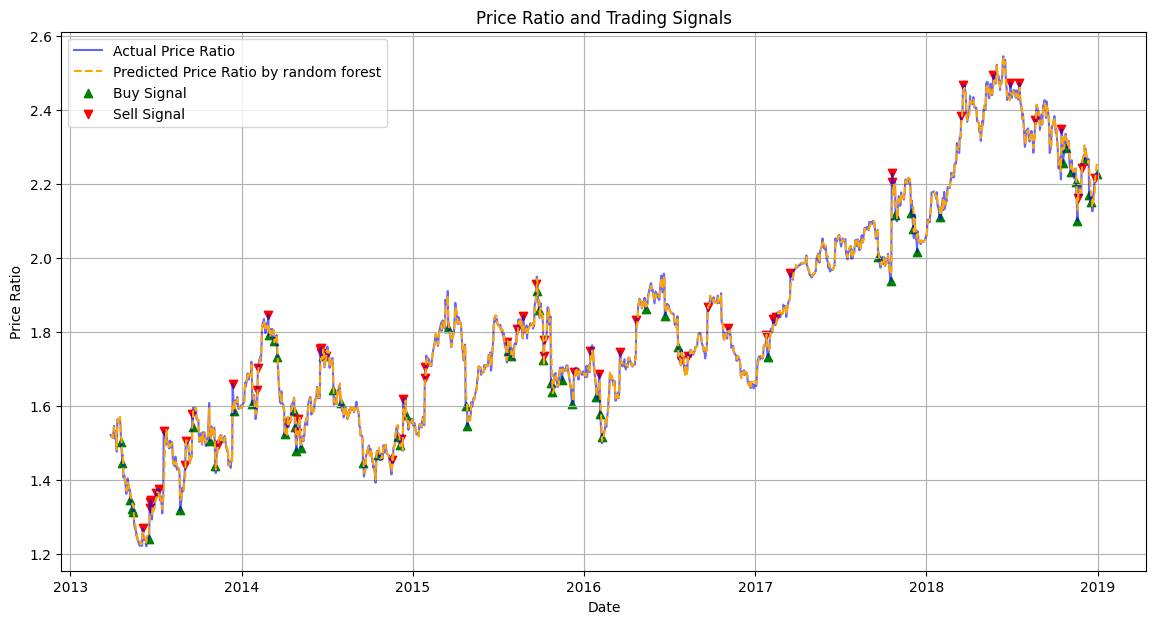

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(data.index, data['ratio'], label='Actual Price Ratio', color='blue', alpha=0.6)
plt.plot(data.index, data['Predicted_Ratio_Rf'], label='Predicted Price Ratio by random forest', color='orange', linestyle='--')

buy_signals = data[data['Signal_rf'] == 'Buy']
sell_signals = data[data['Signal_rf'] == 'Sell']
plt.scatter(buy_signals.index, buy_signals['ratio'], label='Buy Signal', color='green', marker='^', alpha=1)
plt.scatter(sell_signals.index, sell_signals['ratio'], label='Sell Signal', color='red', marker='v', alpha=1)

plt.title('Price Ratio and Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price Ratio')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def simulate_trading_rf(data, initial_balance=100000, transaction_fee=0.001):
  # Deducting a transaction cost to simulate real life stuff *Nirmala Ji :)
    balance = initial_balance
    positions = 0
    total_pnl = 0
    portfolio_value = balance

    # The idea is to save the complete simulation in form of a dataframe and eventually extract as a CSV
    simulation_log = []

    for index, row in data.iterrows():
        trade_action = None  # What to do(Buy/Sell/None(means nothing to or Hold))
        pnl = 0

        # If the signal given by model is Buy and I don't have any existing positions
        if row['Signal_rf'] == 'Buy' and balance > 0:
            balance -= balance * transaction_fee
            positions = balance / row['ADBE']  # How many shares can I take up
            balance = 0  # Exhausted my cash holdings
            trade_action = 'Buy' #Bought assets so trade action is Buying

        # If the signal is Sell and I have a position in the market
        elif row['Signal_rf'] == 'Sell' and positions > 0:
            balance += positions * row['ADBE']  # Exhaust all the stock holdings
            pnl = balance - portfolio_value
            total_pnl += pnl
            balance -= balance * transaction_fee
            positions = 0  # Sold all my holdings
            trade_action = 'Sell'

        portfolio_value = balance + positions * row['ADBE']

        # Saving all the progress of that day
        simulation_log.append({
            'Date': row.name,  # Assuming the index is the date
            'Action': trade_action,
            'Price': row['ADBE'],
            'Balance': balance,
            'Positions': positions,
            'Portfolio_Value': portfolio_value,
            'PnL': pnl,
            'Total_PnL': total_pnl
        })

    # If any position is left at the end, sell that at the last closing price
    if positions > 0:
        balance += positions * data.iloc[-1]['ADBE']
        positions = 0

    # Final portfolio value
    final_portfolio_value = balance
    final_pnl = final_portfolio_value - initial_balance


    simulation_log.append({
        'Date': data.index[-1],
        'Action': 'Final Sell',
        'Price': data.iloc[-1]['ADBE'],
        'Balance': balance,
        'Positions': positions,
        'Portfolio_Value': final_portfolio_value,
        'PnL': 0,
        'Total_PnL': total_pnl
    })

    simulation_df_rf= pd.DataFrame(simulation_log)

    return simulation_df_rf, final_portfolio_value, final_pnl

In [ ]:
simulation_df_rf, final_portfolio_value_rf, final_pnl_rf = simulate_trading_rf(data)

In [ ]:
simulation_df_rf.tail()

,Date,Action,Price,Balance,Positions,Portfolio_Value,PnL,Total_PnL
1447,2018-12-26,Sell,222.949997,186307.795481,0.000000,186307.795481,14881.059468,81517.37195
1448,2018-12-27,None,225.139999,186307.795481,0.000000,186307.795481,0.000000,81517.37195
1449,2018-12-28,None,223.130005,186307.795481,0.000000,186307.795481,0.000000,81517.37195
1450,2018-12-31,Buy,226.240005,0.000000,822.672751,186121.487686,0.000000,81517.37195
1451,2018-12-31,Final Sell,226.240005,186121.487686,0.000000,186121.487686,0.000000,81517.37195


In [ ]:
print(f"Final Portfolio Value:{final_portfolio_value_rf:.2f}")
print(f"Final PnL:{final_pnl_rf:.2f}")

Final Portfolio Value:186121.49
Final PnL:86121.49


# **Model2: XGBoost**

In [ ]:
from xgboost import XGBRegressor

In [ ]:
model2 = XGBRegressor(n_estimators=100, random_state=42, learning_rate=0.1)
model2.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred_2 = model2.predict(X_test)
rmse_2 = mean_squared_error(y_test, y_pred_2, squared=False)
r2_2 = r2_score(y_test, y_pred_2)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
print(f"RMSE: {rmse_2}")
print(f"R^2 Score: {r2_2}")

RMSE: 0.018542860613564714
R^2 Score: 0.9952924016224547


In [ ]:
data['Predicted_Ratio_xgb'] = model2.predict(X)

In [ ]:
def generate_signals_xgb(row):
    if row['Predicted_Ratio_xgb'] > row['ratio'] * 1.01:
        return 'Buy'
    elif row['Predicted_Ratio_xgb'] < row['ratio'] * 0.99:
        return 'Sell'
    else:
        return 'Hold'

In [ ]:
data['Signal_xgb'] = data.apply(generate_signals_xgb, axis=1)

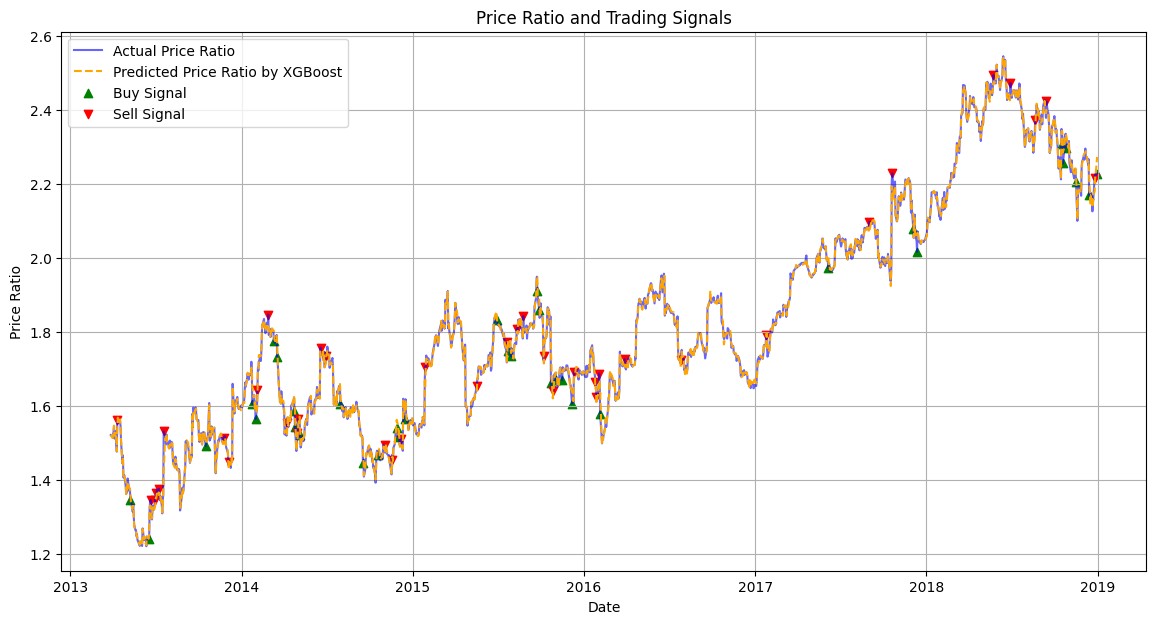

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(data.index, data['ratio'], label='Actual Price Ratio', color='blue', alpha=0.6)
plt.plot(data.index, data['Predicted_Ratio_xgb'], label='Predicted Price Ratio by XGBoost', color='orange', linestyle='--')

buy_signals = data[data['Signal_xgb'] == 'Buy']
sell_signals = data[data['Signal_xgb'] == 'Sell']
plt.scatter(buy_signals.index, buy_signals['ratio'], label='Buy Signal', color='green', marker='^', alpha=1)
plt.scatter(sell_signals.index, sell_signals['ratio'], label='Sell Signal', color='red', marker='v', alpha=1)

plt.title('Price Ratio and Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price Ratio')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def simulate_trading_xgb(data, initial_balance=100000, transaction_fee=0.001):
  # Deducting a transaction cost to simulate real life stuff *Nirmala Ji :)
    balance = initial_balance
    positions = 0
    total_pnl = 0
    portfolio_value = balance

    # The idea is to save the complete simulation in form of a dataframe and eventually extract as a CSV
    simulation_log = []

    for index, row in data.iterrows():
        trade_action = None  # What to do(Buy/Sell/None(means nothing to or Hold))
        pnl = 0

        # If the signal given by model is Buy and I don't have any existing positions
        if row['Signal_xgb'] == 'Buy' and balance > 0:
            balance -= balance * transaction_fee
            positions = balance / row['ADBE']  # How many shares can I take up
            balance = 0  # Exhausted my cash holdings
            trade_action = 'Buy' #Bought assets so trade action is Buying

        # If the signal is Sell and I have a position in the market
        elif row['Signal_xgb'] == 'Sell' and positions > 0:
            balance += positions * row['ADBE']  # Exhaust all the stock holdings
            pnl = balance - portfolio_value
            total_pnl += pnl
            balance -= balance * transaction_fee
            positions = 0  # Sold all my holdings
            trade_action = 'Sell'

        portfolio_value = balance + positions * row['ADBE']

        # Saving all the progress of that day
        simulation_log.append({
            'Date': row.name,
            'Action': trade_action,
            'Price': row['ADBE'],
            'Balance': balance,
            'Positions': positions,
            'Portfolio_Value': portfolio_value,
            'PnL': pnl,
            'Total_PnL': total_pnl
        })

    # If any position is left at the end, sell that at the last closing price
    if positions > 0:
        balance += positions * data.iloc[-1]['ADBE']
        positions = 0

    # Final portfolio value
    final_portfolio_value = balance
    final_pnl = final_portfolio_value - initial_balance


    simulation_log.append({
        'Date': data.index[-1],
        'Action': 'Final Sell',
        'Price': data.iloc[-1]['ADBE'],
        'Balance': balance,
        'Positions': positions,
        'Portfolio_Value': final_portfolio_value,
        'PnL': 0,
        'Total_PnL': total_pnl
    })

    simulation_df = pd.DataFrame(simulation_log)

    return simulation_df, final_portfolio_value, final_pnl

In [ ]:
simulation_df, final_portfolio_value, final_pnl = simulate_trading_xgb(data)

In [ ]:
simulation_df.tail()

,Date,Action,Price,Balance,Positions,Portfolio_Value,PnL,Total_PnL
1447,2018-12-26,Sell,222.949997,193628.157238,0.000000,193628.157238,15465.762531,27014.058948
1448,2018-12-27,None,225.139999,193628.157238,0.000000,193628.157238,0.000000,27014.058948
1449,2018-12-28,None,223.130005,193628.157238,0.000000,193628.157238,0.000000,27014.058948
1450,2018-12-31,Buy,226.240005,0.000000,854.997014,193434.529081,0.000000,27014.058948
1451,2018-12-31,Final Sell,226.240005,193434.529081,0.000000,193434.529081,0.000000,27014.058948


In [ ]:
print(f"Final Portfolio Value:{final_portfolio_value:.2f}")
print(f"Final PnL:{final_pnl:.2f}")

Final Portfolio Value:193434.53
Final PnL:93434.53


# **Non-matching signals between XGBoost and Random Forests**

In [ ]:
eq = 0
for i in range(len(data)):
  if(data['Signal_rf'][i]!=data['Signal_xgb'][i]):
    eq+=1
print(eq)

90


<ipython-input-223-439db76313dd>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(data['Signal_rf'][i]!=data['Signal_xgb'][i]):


In [ ]:
rows = data[data['Signal_rf']!=data['Signal_xgb']]
rows.head()

,ADBE,MSFT,ratio,SMA_5,SMA_20,SMA_60,ROC_5,std,Lag_1,Lag_2,Lag_3,Predicted_Ratio_Rf,Signal_rf,Predicted_Ratio_xgb,Signal_xgb
Date,,,,,,,,,,,,,,,
2013-04-11,45.209999,28.940001,1.562198,1.514660,1.506141,1.440811,1.060513,0.057591,1.476222,1.491726,1.531654,1.548377,Hold,1.546424,Sell
2013-04-19,44.740002,29.770000,1.502855,1.544418,1.527356,1.456173,-3.914712,0.063692,1.544286,1.557406,1.562996,1.524166,Buy,1.508895,Hold
2013-04-22,44.529999,30.830000,1.444372,1.522383,1.523521,1.457258,-7.087345,0.062910,1.502855,1.544286,1.557406,1.464924,Buy,1.445864,Hold
2013-05-13,43.610001,33.029999,1.320315,1.351181,1.416651,1.456189,-4.150081,0.065975,1.346589,1.346295,1.373750,1.334885,Buy,1.320706,Hold
2013-05-14,44.040001,33.529999,1.313451,1.340080,1.404174,1.455094,-4.054722,0.067795,1.320315,1.346589,1.346295,1.330938,Buy,1.326574,Hold


The only reason I am able to think of is that XGBoost gives better results than Random forests in general so the random forests algo gave some poor results and blaimed algo and features for this.
If there is any another reason please tell...